# Comprehensive Weather Analysis for Durham, NC
 (Weather Underground sensors only)

This notebook performs a comprehensive analysis of weather sensor data collected across Durham, North Carolina, as part of the **"Durham Environmental Monitoring" research project**. 

The primary goal is to explore, clean, and model hyperlocal weather data to understand patterns, detect anomalies, and forecast key metrics like **temperature, humidity, and atmospheric pressure**.

**Analysis Steps:**
1.  **Setup & Authentication:** Installs dependencies and connects to Google BigQuery.
2.  **Data Loading & Cleaning:** Fetches raw data within a specified date range and performs cleaning and standardization.
3.  **Exploratory Data Analysis (EDA):** Visualizes the data through time series plots, a sensor correlation heatmap, and a spatial map.
4.  **Anomaly Detection:** Uses Isolation Forest and Z-score methods to identify unusual data points.
5.  **Forecasting with Prophet:** Builds both global (city-wide average) and per-sensor forecast models.
6.  **Summary & Exports:** Generates key insights and exports all artifacts (plots, data, and forecasts).

**To run this notebook:**
-   Set the `GCP_SA_KEY_JSON` environment variable in your Deepnote project with your Google Cloud service account key.
-   Upload the accompanying `requirements.txt` file.

## 1 — Setup & Environment

This first cell installs all the necessary Python packages from the `requirements.txt` file. For a cleaner presentation in Deepnote's article view, the code and output of this cell are hidden by default.

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary libraries
import os, warnings, math, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from google.cloud import bigquery
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
import missingno as msno

# Configure plotting and warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)

# Configure Kaleido for static image exports (replaces deprecated 'scope')
pio.templates.default = "plotly_white"
pio.defaults.default_format = "png"
pio.defaults.default_width = 1400
pio.defaults.default_height = 900

print('Environment ready.')

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Environment ready.


## 2 — Configuration & Authentication

All user-configurable parameters and the authentication logic for Google Cloud are centralized here.

In [3]:
# --- Main Configuration ---
BQ_PROJECT = 'durham-weather-466502'
BQ_DATASET = 'sensors_shared'
BQ_TABLE = 'wu_raw_view'
START_DATE = '2025-07-01'
END_DATE = '2025-10-10'

# Forecasting Parameters
FORECAST_DAYS_GLOBAL = 30
FORECAST_DAYS_SENSOR = 14
RUN_PER_SENSOR_FORECASTS = True # Set to False to only run the global forecast

# Output Directory
OUT_DIR = './weather_analysis_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
print(f'Outputs will be written to {OUT_DIR}')

# --- GCP Authentication ---
sa_json = os.environ.get('GCP_SA_KEY_JSON')
if not sa_json:
    raise RuntimeError('GCP_SA_KEY_JSON not set in environment. Add it in Deepnote Project -> Environment.')

creds_path = './gcp-key.json'
with open(creds_path, 'w') as f:
    f.write(sa_json)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = creds_path
client = bigquery.Client(project=BQ_PROJECT)
print(f'BigQuery client initialized for project {client.project}')

Outputs will be written to ./weather_analysis_outputs
BigQuery client initialized for project durham-weather-466502


## 3 — Data Loading & Initial Exploration

We'll start by querying BigQuery to get a quick count of the data and a small sample to ensure the connection and schema are correct.

In [4]:
count_sql = f"""
SELECT COUNT(*) AS total_rows
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE ts BETWEEN '{START_DATE}' AND '{END_DATE}'
"""
count_df = client.query(count_sql).to_dataframe()
print(f"Total rows for range: {int(count_df['total_rows'].iloc[0])}")

sample_sql = f"""
SELECT ts, native_sensor_id, humidity, temperature, pressure_max, pressure_min, lat, lon
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE ts BETWEEN '{START_DATE}' AND '{END_DATE}'
ORDER BY ts
LIMIT 10
"""
display(client.query(sample_sql).to_dataframe())

Total rows for range: 22231


,ts,native_sensor_id,humidity,temperature,pressure_max,pressure_min,lat,lon
0,2025-07-04 04:58:00+00:00,KNCDURHA655,88.3,73.1,29.81,29.79,35.899,-78.917
1,2025-07-04 04:59:00+00:00,KNCDURHA656,91.1,72.3,29.86,29.84,35.978,-78.949
2,2025-07-04 04:59:00+00:00,KNCDURHA652,92.9,72.7,29.99,29.97,35.962,-78.996
3,2025-07-04 04:59:00+00:00,KNCDURHA653,88.2,74.0,29.79,29.78,35.977,-78.919
4,2025-07-04 04:59:00+00:00,KNCDURHA649,83.1,75.7,29.94,29.92,35.986,-78.902
5,2025-07-04 04:59:52+00:00,KNCDURHA616,91.5,73.9,29.93,29.92,35.989,-78.928
6,2025-07-04 04:59:52+00:00,KNCDURHA609,88.0,74.6,30.01,30.01,35.999,-78.917
7,2025-07-04 04:59:52+00:00,KNCDURHA617,89.9,72.7,30.17,30.16,36.000,-78.931
8,2025-07-04 04:59:52+00:00,KNCDURHA610,93.2,71.8,30.13,30.12,36.054,-78.972
9,2025-07-04 04:59:52+00:00,KNCDURHA623,88.3,74.4,30.05,30.04,35.991,-78.887


In [5]:
# Load the full dataset for the specified date range
sql = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE ts BETWEEN '{START_DATE}' AND '{END_DATE}'
ORDER BY ts
"""
print('Running query to load full dataset...')
df_raw = client.query(sql).to_dataframe()
df_raw['ts'] = pd.to_datetime(df_raw['ts'], utc=True)
print(f'Loaded {df_raw.shape[0]} rows and {df_raw.shape[1]} columns.')
display(df_raw.head(3))

Running query to load full dataset...
Loaded 22231 rows and 46 columns.


,ts,native_sensor_id,tz,obsTimeLocal,lat,lon,solar_radiation,uv_high,wind_direction_avg,humidity_high,humidity_low,humidity,qc_status,dew_point_avg,dew_point_high,dew_point_low,heat_index_avg,heat_index_high,heat_index_low,precip_rate,precip_total,pressure_max,pressure_min,pressure_trend,temperature,temperature_high,temperature_low,wind_chill_avg,wind_chill_high,wind_chill_low,wind_gust_avg,wind_gust_high,wind_gust_low,wind_speed_avg,wind_speed_high,wind_speed_low,lat_f,lon_f,latitude,longitude,geog,sensor_id,source,effective_start_date,effective_end_date,updated_at
0,2025-07-04 04:58:00+00:00,KNCDURHA655,America/New_York,2025-07-04 00:58:00,35.899,-78.917,0.0,0.0,237.0,89.0,87.0,88.3,1,69.4,69.8,69.2,74.3,75.0,73.9,0.0,0.0,29.81,29.79,0.01,73.1,73.8,72.7,73.1,73.8,72.7,0.0,0.0,0.0,0.0,0.0,0.0,35.899,-78.917,NaN,NaN,None,KNCDURHA655,seed:identity,NaT,NaT,2025-10-14 07:24:51.467319+00:00
1,2025-07-04 04:59:00+00:00,KNCDURHA653,America/New_York,2025-07-04 00:59:00,35.977,-78.919,0.0,0.0,17.0,89.0,87.0,88.2,1,70.3,70.5,70.0,75.2,75.7,74.6,0.0,0.0,29.79,29.78,0.00,74.0,74.5,73.4,74.0,74.5,73.4,0.0,0.0,0.0,0.0,0.0,0.0,35.977,-78.919,NaN,NaN,None,KNCDURHA653,seed:identity,NaT,NaT,2025-10-14 07:24:51.467319+00:00
2,2025-07-04 04:59:00+00:00,KNCDURHA652,America/New_York,2025-07-04 00:59:00,35.962,-78.996,0.0,0.0,162.0,94.0,92.0,92.9,1,70.5,70.9,70.0,74.0,74.8,73.4,0.0,0.0,29.99,29.97,0.02,72.7,73.4,72.1,72.7,73.4,72.1,0.0,1.1,0.0,0.0,0.2,0.0,35.962,-78.996,NaN,NaN,None,KNCDURHA652,seed:identity,NaT,NaT,2025-10-14 07:24:51.467319+00:00


## 4 — Data Cleaning & Preprocessing

Here, we clean the raw data by standardizing column names, handling data types, creating a composite `pressure_avg` metric, and performing basic validation (e.g., ensuring humidity is between 0-100).

In [6]:
df = df_raw.copy()

# Ensure sensor ID column is present and is a string
if 'native_sensor_id' not in df.columns:
    df['native_sensor_id'] = df.get('sensor_id', 'unknown').astype(str)
else:
    df['native_sensor_id'] = df['native_sensor_id'].astype(str)

# Create an average pressure metric
if 'pressure_max' in df.columns and 'pressure_min' in df.columns:
    df['pressure_avg'] = (pd.to_numeric(df['pressure_max'], errors='coerce') + pd.to_numeric(df['pressure_min'], errors='coerce')) / 2

# Standardize timestamps and create a date column
LOCAL_TZ = 'UTC'
df['ts_local'] = df['ts'].dt.tz_convert(LOCAL_TZ)
df['date'] = df['ts_local'].dt.floor('D')

# Ensure key metrics are numeric and handle invalid values
numeric_cols = ['humidity','temperature','pressure_avg','wind_speed_avg','precip_total','solar_radiation','uv_high']
numeric_cols = [c for c in numeric_cols if c in df.columns]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Basic data validation
if 'humidity' in df.columns:
    df.loc[(df['humidity'] < 0) | (df['humidity'] > 100), 'humidity'] = np.nan

print(f'After cleaning, rows: {df.shape[0]}, numeric cols: {numeric_cols}')
display(df[numeric_cols].describe().transpose())

After cleaning, rows: 22231, numeric cols: ['humidity', 'temperature', 'pressure_avg', 'wind_speed_avg', 'precip_total', 'solar_radiation', 'uv_high']


,count,mean,std,min,25%,50%,75%,max
humidity,22231.0,77.511929,17.581370,29.00,63.20,83.10,93.00,99.000
temperature,22231.0,74.921205,9.266518,49.80,68.60,74.90,80.90,101.300
pressure_avg,22231.0,29.992514,0.163955,29.56,29.87,29.98,30.10,30.555
wind_speed_avg,22231.0,0.340722,0.476039,0.00,0.00,0.10,0.50,3.600
precip_total,22231.0,0.049064,0.246205,0.00,0.00,0.00,0.00,3.480
solar_radiation,22231.0,207.188691,313.082457,0.00,0.00,33.00,286.85,2223.500
uv_high,22231.0,1.719702,2.855030,0.00,0.00,0.00,2.00,15.000


### Temporal Aggregation

To analyze trends over different time scales, we'll aggregate the data into daily and weekly averages.

In [7]:
def aggregate(df_in, freq='D', metrics=None):
    if metrics is None:
        metrics = ['humidity','temperature','pressure_avg','wind_speed_avg','precip_total']
    metrics = [m for m in metrics if m in df_in.columns]
    agg = df_in.set_index('ts_local').groupby([pd.Grouper(freq=freq), 'native_sensor_id'])[metrics].mean().reset_index()
    return agg

daily = aggregate(df, freq='D')
weekly = aggregate(df, freq='W')

daily.to_csv(os.path.join(OUT_DIR,'daily_aggregated_by_sensor.csv'), index=False)

print(f'Aggregated data points: Daily ({daily.shape[0]}), Weekly ({weekly.shape[0]})')

Aggregated data points: Daily (1119), Weekly (180)


## 5 — Exploratory Data Analysis (EDA)

Now we'll visualize the cleaned data to identify patterns, correlations, and outliers.

### Data Quality & Missingness

The `missingno` matrix gives us a quick visual overview of where data is missing across the dataset. Solid bars indicate data presence.

Rows: 22231, Columns: 49

Missing % (sample metrics):
  humidity: 0.0% missing
  temperature: 0.0% missing
  pressure_avg: 0.0% missing
  wind_speed_avg: 0.0% missing
  precip_total: 0.0% missing


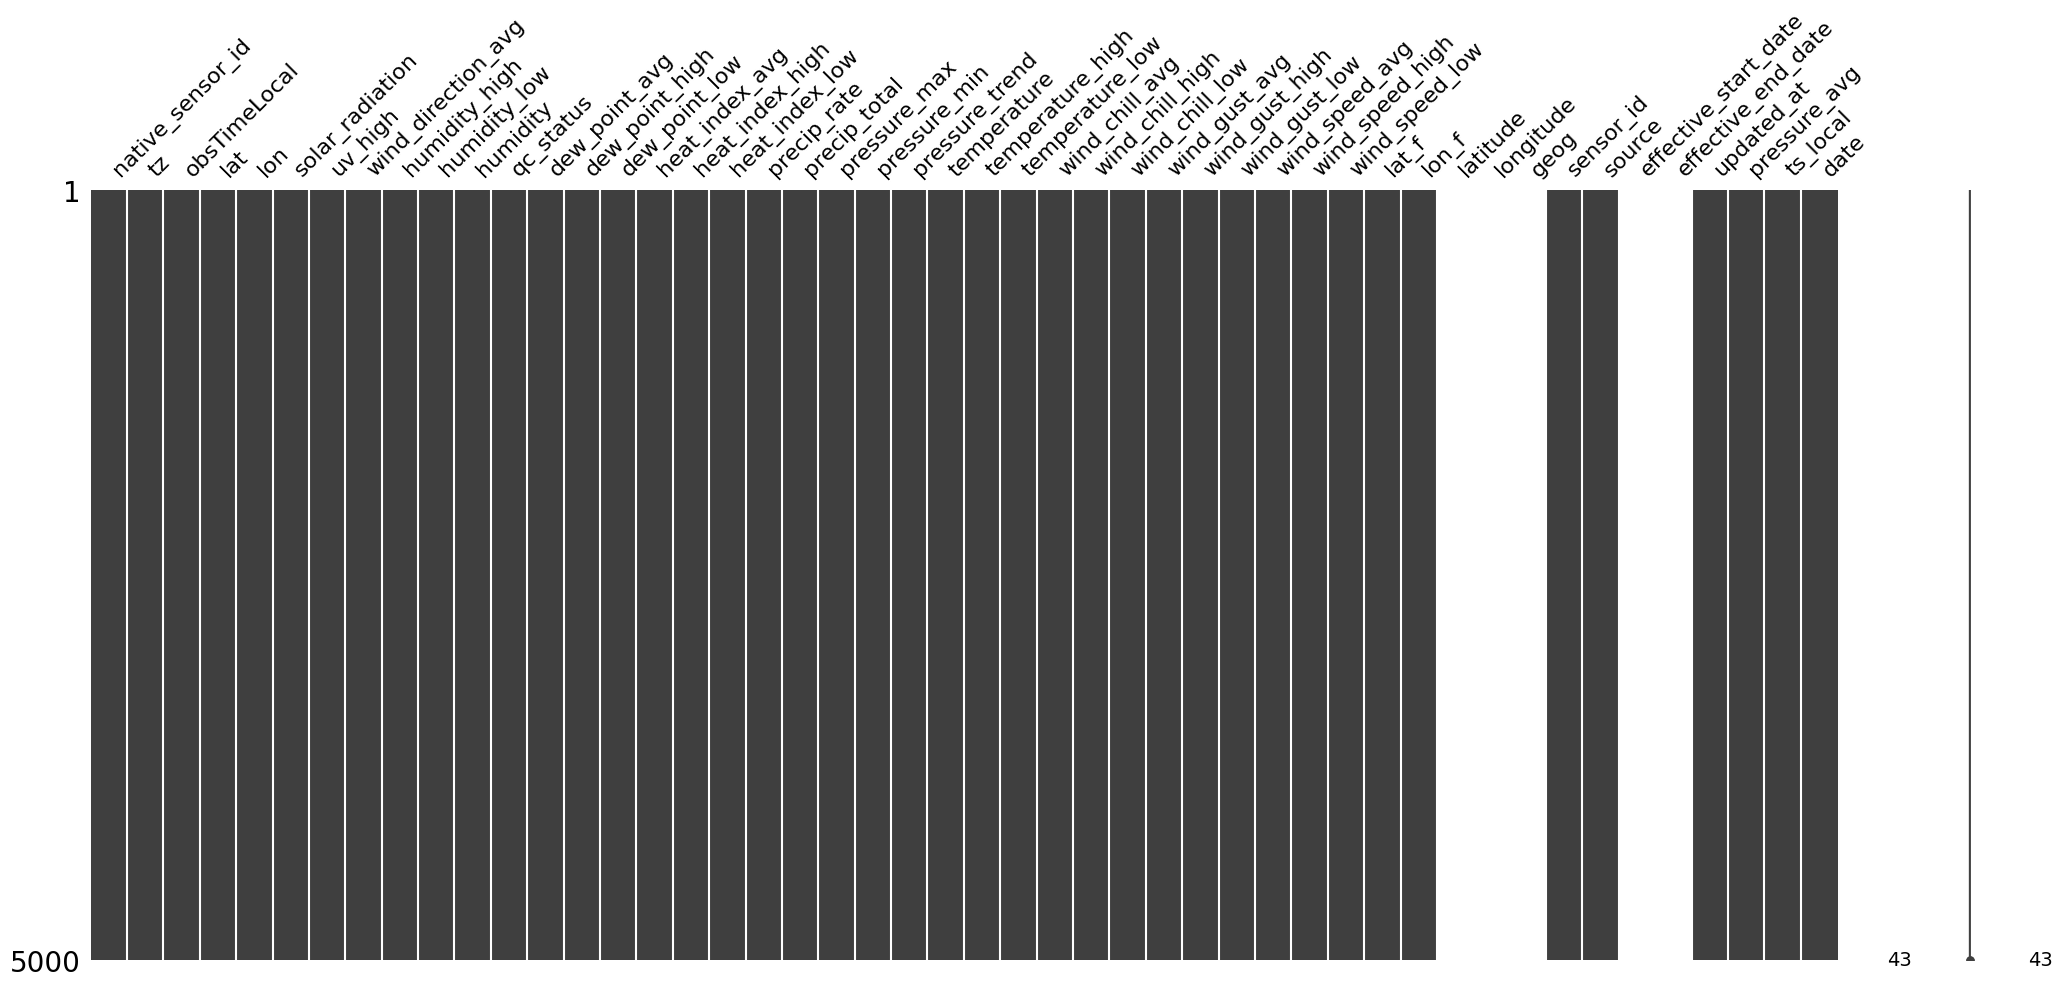

In [8]:
def data_quality(df_in):
    print(f'Rows: {df_in.shape[0]}, Columns: {df_in.shape[1]}\n')
    print('Missing % (sample metrics):')
    for c in ['humidity','temperature','pressure_avg','wind_speed_avg','precip_total']:
        if c in df_in.columns:
            print(f'  {c}: {round(df_in[c].isnull().mean()*100, 2)}% missing')
    
data_quality(df)
msno.matrix(df.sample(min(5000, len(df))).set_index('ts'))
plt.show()

### Interactive Time Series

Plotting each sensor's daily average for key metrics allows us to compare their behavior over time. The interactive plots let you zoom and hover to inspect specific points.

In [9]:
def plot_multi_metric(metric, df_agg=daily, out_dir=OUT_DIR):
    df_plot = df_agg.pivot(index='ts_local', columns='native_sensor_id', values=metric).sort_index()
    fig = go.Figure()
    for s in df_plot.columns:
        fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot[s], mode='lines+markers', name=str(s), hoverinfo='name+y'))
    fig.update_layout(title=f'Daily Average {metric.replace("_"," ").title()} per Sensor', xaxis_title='Date', yaxis_title=metric, height=600)
    out_html = os.path.join(out_dir, f'time_series_{metric}_daily.html')
    # Use include_plotlyjs='cdn' to reduce file size
    fig.write_html(out_html, include_plotlyjs='cdn')
    fig.show()

for m in ['humidity','temperature','pressure_avg']:
    if m in df.columns:
        plot_multi_metric(m)

### Sensor Correlation

This heatmap shows the correlation between the daily humidity readings of different sensors. A high value (close to 1.0) indicates that two sensors report very similar patterns.

In [10]:
daily_pivot = daily.pivot(index='ts_local', columns='native_sensor_id', values='humidity')
daily_pivot_interp = daily_pivot.interpolate(method='time') # Interpolate to handle NaNs for correlation
corr = daily_pivot_interp.corr()
fig = px.imshow(corr, title='Sensor Correlation (Daily Humidity)', labels=dict(x='Sensor', y='Sensor', color='Corr'))
corr_html = os.path.join(OUT_DIR,'sensor_correlation.html')
fig.write_html(corr_html, include_plotlyjs='cdn')
fig.show()

### Spatial Distribution

This map plots the geographic location of each sensor, with the color representing its average humidity over the analysis period. This can help identify spatial patterns in the data.

In [11]:
if 'lat' in df.columns and 'lon' in df.columns:
    locs = df.groupby('native_sensor_id').agg({'lat':'first','lon':'first','humidity':'mean'}).reset_index()
    fig = px.scatter_mapbox(locs, lat='lat', lon='lon', color='humidity', 
                          hover_name='native_sensor_id', size_max=12, zoom=10, 
                          mapbox_style='open-street-map', title='Sensor Locations Colored by Mean Humidity')
    map_html = os.path.join(OUT_DIR,'sensor_map.html')
    fig.write_html(map_html, include_plotlyjs='cdn')
    fig.show()
else:
    print('lat/lon not present; skipping map.')

## 6 — Anomaly Detection

We apply two methods to detect anomalies in daily humidity data for each sensor: **Isolation Forest** (a machine learning model) and a **rolling Z-score** (a statistical method).

In [12]:
anomaly_list = []
daily_hum = daily.pivot(index='ts_local', columns='native_sensor_id', values='humidity').interpolate(method='time')

for sensor in daily_hum.columns:
    s = daily_hum[sensor].dropna()
    if len(s) < 30: # Need sufficient data to model
        continue
    
    X = s.values.reshape(-1,1)
    
    # Isolation Forest
    clf = IsolationForest(contamination=0.02, random_state=42)
    clf.fit(X)
    is_anom = clf.predict(X) == -1
    
    # Rolling Z-score
    rolling_mean = s.rolling(7, min_periods=3).mean()
    rolling_std = s.rolling(7, min_periods=3).std()
    z = (s - rolling_mean) / rolling_std
    z_flag = z.abs() > 3
    
    tmp = pd.DataFrame({'date': s.index, 'sensor': sensor, 'value': s.values, 'iforest_anomaly': is_anom, 'zscore_anomaly': z_flag.values})
    anomaly_list.append(tmp)

if anomaly_list:
    anoms_df = pd.concat(anomaly_list, ignore_index=True)
    anoms_df.to_csv(os.path.join(OUT_DIR,'anomalies_by_sensor.csv'), index=False)
    print(f'Saved anomalies to {os.path.join(OUT_DIR, "anomalies_by_sensor.csv")}')
    display(anoms_df[anoms_df['iforest_anomaly'] | anoms_df['zscore_anomaly']])
else:
    print("No anomalies detected or insufficient data.")

Saved anomalies to ./weather_analysis_outputs/anomalies_by_sensor.csv


,date,sensor,value,iforest_anomaly,zscore_anomaly
33,2025-08-06 00:00:00+00:00,KNCDURHA609,96.850,True,False
53,2025-08-26 00:00:00+00:00,KNCDURHA609,56.695,True,False
131,2025-08-06 00:00:00+00:00,KNCDURHA610,95.430,True,False
195,2025-10-09 00:00:00+00:00,KNCDURHA610,62.070,True,False
229,2025-08-06 00:00:00+00:00,KNCDURHA616,98.055,True,False
249,2025-08-26 00:00:00+00:00,KNCDURHA616,58.075,True,False
348,2025-08-27 00:00:00+00:00,KNCDURHA617,65.450,True,False
391,2025-10-09 00:00:00+00:00,KNCDURHA617,63.370,True,False
393,2025-07-05 00:00:00+00:00,KNCDURHA623,68.030,True,False
489,2025-10-09 00:00:00+00:00,KNCDURHA623,54.945,True,False


## 7 — Time Series Forecasting with Prophet

This section builds forecast models using Meta's Prophet library. We create a global model based on the average of all sensors and, optionally, individual models for each sensor.

### Forecasting Function Definition

This helper function encapsulates the entire Prophet workflow: fitting the model, making a prediction, evaluating performance (RMSE and MAPE), and generating an interactive plot.

In [13]:
from sklearn.metrics import mean_squared_error

def mape(y_true, y_pred):
    """Calculates Mean Absolute Percentage Error, safely ignoring division by zero."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask): return np.nan
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100

def run_prophet(series, periods, out_prefix, color=None, smooth_window=7):
    """Runs the Prophet forecast, evaluates, and plots the results."""
    dfp = series.reset_index().rename(columns={series.index.name: 'ds', series.name: 'y'})
    dfp['ds'] = pd.to_datetime(dfp['ds']).dt.tz_localize(None) # Prophet requires tz-naive
    dfp['y'] = pd.to_numeric(dfp['y'], errors='coerce').dropna()

    if len(dfp) < 30:
        print(f'Skipping {out_prefix}: not enough data points ({len(dfp)}).')
        return None

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(dfp)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Save CSV
    csv_path = os.path.join(OUT_DIR, f'{out_prefix}_forecast.csv')
    forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv(csv_path, index=False)
    
    # Evaluate model performance on historical data
    fc_hist = forecast.set_index('ds').loc[dfp['ds']]
    y_true = dfp['y'].values
    y_pred = fc_hist['yhat'].values
    metrics = {
        'out_prefix': out_prefix,
        'n_train_points': len(dfp),
        'rmse': math.sqrt(mean_squared_error(y_true, y_pred)),
        'mape': mape(y_true, y_pred)
    }

    # Plotting
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill=None, mode='lines', line_color='rgba(0,176,246,0.2)', name='Upper Bound'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='lines', line_color='rgba(0,176,246,0.2)', name='Uncertainty Band'))
    fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast (yhat)', line=dict(color=color or 'royalblue', width=2)))
    smooth = dfp.set_index('ds')['y'].rolling(smooth_window, min_periods=1).mean()
    fig.add_trace(go.Scatter(x=smooth.index, y=smooth.values, mode='lines', name=f'Historical Trend ({smooth_window}d MA)', line=dict(color='darkorange', dash='dash')))
    fig.add_trace(go.Scatter(x=dfp['ds'], y=dfp['y'], mode='markers', name='Observed History', marker=dict(size=6, color='black', opacity=0.6)))
    
    fig.update_layout(title=f'Prophet Forecast: {out_prefix.replace("_", " ").title()}', xaxis_title='Date', yaxis_title=series.name, height=650)
    html_path = os.path.join(OUT_DIR, f'{out_prefix}_forecast.html')
    fig.write_html(html_path, include_plotlyjs='cdn') # Use CDN to reduce file size

    return {'csv': csv_path, 'html': html_path, 'metrics': metrics}

### Global Average Forecasts

First, we generate forecasts for the city-wide average of each key metric.

In [14]:
metrics_list = []
metrics_for_forecast = [m for m in ['humidity','temperature','pressure_avg'] if m in df.columns]
print(f'Metrics to forecast: {metrics_for_forecast}')

# --- Global Forecasts ---
for metric in metrics_for_forecast:
    print(f'\nRunning global forecast for {metric}...')
    pivot = daily.pivot(index='ts_local', columns='native_sensor_id', values=metric)
    global_series = pivot.interpolate(method='time').mean(axis=1).rename(metric)
    
    out = run_prophet(global_series, FORECAST_DAYS_GLOBAL, f'global_{metric}')
    if out:
        print(f"  -> Saved global forecast for {metric} to {out['html']}")
        metrics_list.append(out['metrics'])

00:07:19 - cmdstanpy - INFO - Chain [1] start processing
Metrics to forecast: ['humidity', 'temperature', 'pressure_avg']

Running global forecast for humidity...
00:07:19 - cmdstanpy - INFO - Chain [1] done processing
00:07:19 - cmdstanpy - INFO - Chain [1] start processing
  -> Saved global forecast for humidity to ./weather_analysis_outputs/global_humidity_forecast.html

Running global forecast for temperature...
00:07:19 - cmdstanpy - INFO - Chain [1] done processing
00:07:20 - cmdstanpy - INFO - Chain [1] start processing
  -> Saved global forecast for temperature to ./weather_analysis_outputs/global_temperature_forecast.html

Running global forecast for pressure_avg...
00:07:20 - cmdstanpy - INFO - Chain [1] done processing
  -> Saved global forecast for pressure_avg to ./weather_analysis_outputs/global_pressure_avg_forecast.html


### Per-Sensor Forecasts

Next, if enabled in the configuration, we generate a separate forecast for each individual sensor.

In [15]:
# --- Per-Sensor Forecasts ---
if RUN_PER_SENSOR_FORECASTS:
    sensors = sorted(df['native_sensor_id'].unique())
    PALETTE = px.colors.qualitative.Plotly
    
    for metric in metrics_for_forecast:
        print(f'\nRunning per-sensor forecasts for {metric}...')
        pivot = daily.pivot(index='ts_local', columns='native_sensor_id', values=metric).interpolate(method='time')
        
        for i, sensor in enumerate(pivot.columns):
            series = pivot[sensor].dropna().rename(metric)
            key = f'{sensor}_{metric}'
            color = PALETTE[i % len(PALETTE)]
            
            out = run_prophet(series, FORECAST_DAYS_SENSOR, key, color=color)
            if out:
                metrics_list.append(out['metrics'])
                print(f'  -> Saved per-sensor forecast for: {key}')
else:
    print('Skipping per-sensor forecasts as per configuration.')

00:07:20 - cmdstanpy - INFO - Chain [1] start processing
00:07:21 - cmdstanpy - INFO - Chain [1] done processing

Running per-sensor forecasts for humidity...
00:07:21 - cmdstanpy - INFO - Chain [1] start processing
  -> Saved per-sensor forecast for: KNCDURHA609_humidity
00:07:21 - cmdstanpy - INFO - Chain [1] done processing
00:07:21 - cmdstanpy - INFO - Chain [1] start processing
  -> Saved per-sensor forecast for: KNCDURHA610_humidity
00:07:22 - cmdstanpy - INFO - Chain [1] done processing
00:07:22 - cmdstanpy - INFO - Chain [1] start processing
  -> Saved per-sensor forecast for: KNCDURHA616_humidity
00:07:22 - cmdstanpy - INFO - Chain [1] done processing
00:07:23 - cmdstanpy - INFO - Chain [1] start processing
  -> Saved per-sensor forecast for: KNCDURHA617_humidity
00:07:23 - cmdstanpy - INFO - Chain [1] done processing
00:07:23 - cmdstanpy - INFO - Chain [1] start processing
  -> Saved per-sensor forecast for: KNCDURHA623_humidity
00:07:23 - cmdstanpy - INFO - Chain [1] done pr

## 8 — Summary of Outputs

Finally, we'll save the forecast performance metrics and display a summary of key insights derived from the analysis.

In [16]:
# Save all collected metrics to a single CSV
if metrics_list:
    metrics_df = pd.DataFrame(metrics_list)
    metrics_csv = os.path.join(OUT_DIR, 'forecast_metrics.csv')
    metrics_df.to_csv(metrics_csv, index=False)
    print(f'Saved forecast metrics to {metrics_csv}')
    display(metrics_df.head())

# Generate and save a text summary of insights
insights = []
sensor_days = daily.groupby('native_sensor_id')['ts_local'].nunique().rename('days_present').reset_index()
date_range_len = (daily['ts_local'].max() - daily['ts_local'].min()).days + 1
sensor_days['pct_coverage'] = (sensor_days['days_present'] / date_range_len * 100).round(2)
top_cov = sensor_days.sort_values('pct_coverage', ascending=False).head(5)
insights.append('Top 5 sensors by data coverage (% of days with data):')
insights.extend([f"- {row.native_sensor_id}: {row.pct_coverage}%" for index, row in top_cov.iterrows()])

if 'anoms_df' in locals() and not anoms_df.empty:
    anom_counts = anoms_df.groupby('sensor')['iforest_anomaly'].sum().sort_values(ascending=False).head(5)
    insights.append('\nTop 5 sensors with most anomalies (IsolationForest):')
    insights.extend([f"- {s} ({int(c)} anomalies)" for s,c in anom_counts.items() if c > 0])

insights.append(f'\nAnalysis period: {START_DATE} to {END_DATE}')

insights_summary = '\n'.join(insights)
insights_path = os.path.join(OUT_DIR,'insights_summary.txt')
with open(insights_path, 'w') as f:
    f.write(insights_summary)

print('\n--- Insights Summary ---')
print(insights_summary)

Saved forecast metrics to ./weather_analysis_outputs/forecast_metrics.csv


,out_prefix,n_train_points,rmse,mape
0,global_humidity,98,109.258825,120.715202
1,global_temperature,98,130.308540,144.077124
2,global_pressure_avg,98,140.863651,441.597528
3,KNCDURHA609_humidity,98,271.264888,335.957133
4,KNCDURHA610_humidity,98,114.438944,115.573192



--- Insights Summary ---
Top 5 sensors by data coverage (% of days with data):
- KNCDURHA653: 98.98%
- KNCDURHA656: 98.98%
- KNCDURHA649: 97.96%
- KNCDURHA617: 97.96%
- KNCDURHA655: 95.92%

Top 5 sensors with most anomalies (IsolationForest):
- KNCDURHA609 (2 anomalies)
- KNCDURHA610 (2 anomalies)
- KNCDURHA616 (2 anomalies)
- KNCDURHA617 (2 anomalies)
- KNCDURHA623 (2 anomalies)

Analysis period: 2025-07-01 to 2025-10-10


In [29]:
# --- Step 1: Install Google Chrome for Kaleido ---
# In some environments, Kaleido needs a full version of Chrome to be installed.
# We first add Google's official repository and key, then update the package list, and finally install Chrome.
# The code and output of this cell can be hidden in your final published notebook for a cleaner look.
!wget -q -O - https://dl.google.com/linux/linux_signing_key.pub | sudo apt-key add -
!echo "deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main" | sudo tee /etc/apt/sources.list.d/google-chrome.list
!sudo apt-get update -y
!sudo apt-get install -y google-chrome-stable

OK
deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main
Hit:1 http://deb.debian.org/debian bullseye InRelease
Hit:2 http://deb.debian.org/debian-security bullseye-security InRelease
Hit:3 http://deb.debian.org/debian bullseye-updates InRelease
Hit:4 http://dl.google.com/linux/chrome/deb stable InRelease




google-chrome-stable is already the newest version (141.0.7390.107-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA609_humidity.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA609_pressure_avg.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA609_temperature.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA610_humidity.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA610_pressure_avg.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA610_temperature.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA616_humidity.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA616_pressure_avg.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA616_temperature.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA617_humidity.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA617_pressure_avg.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA617_temperature.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA623_humidity.png
Saved PNG: ./weather_analysis_outputs/pngs/KNCDURHA623_pressure_avg.png
Saved PNG: ./wea

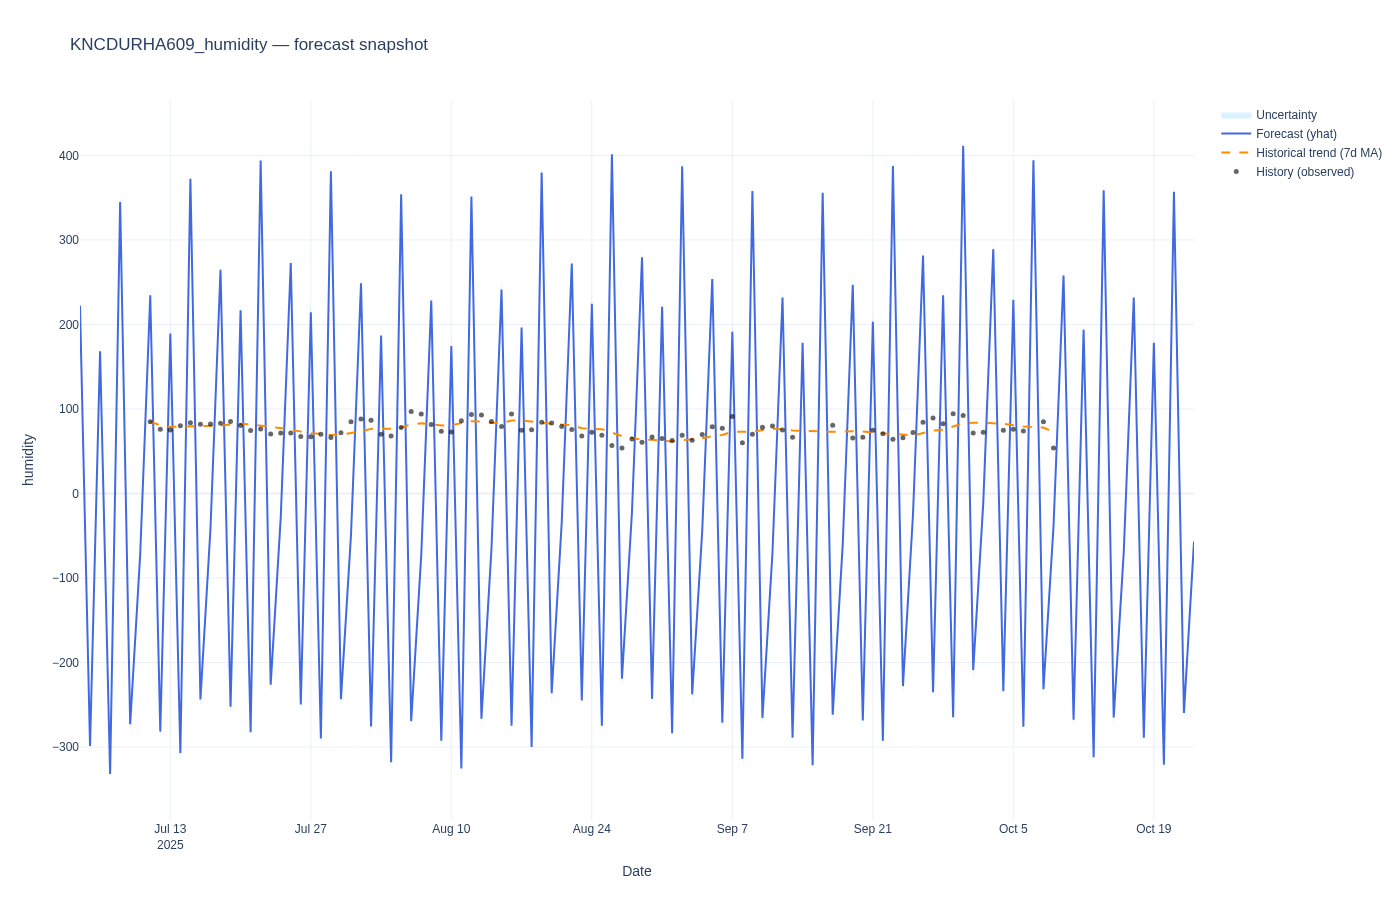

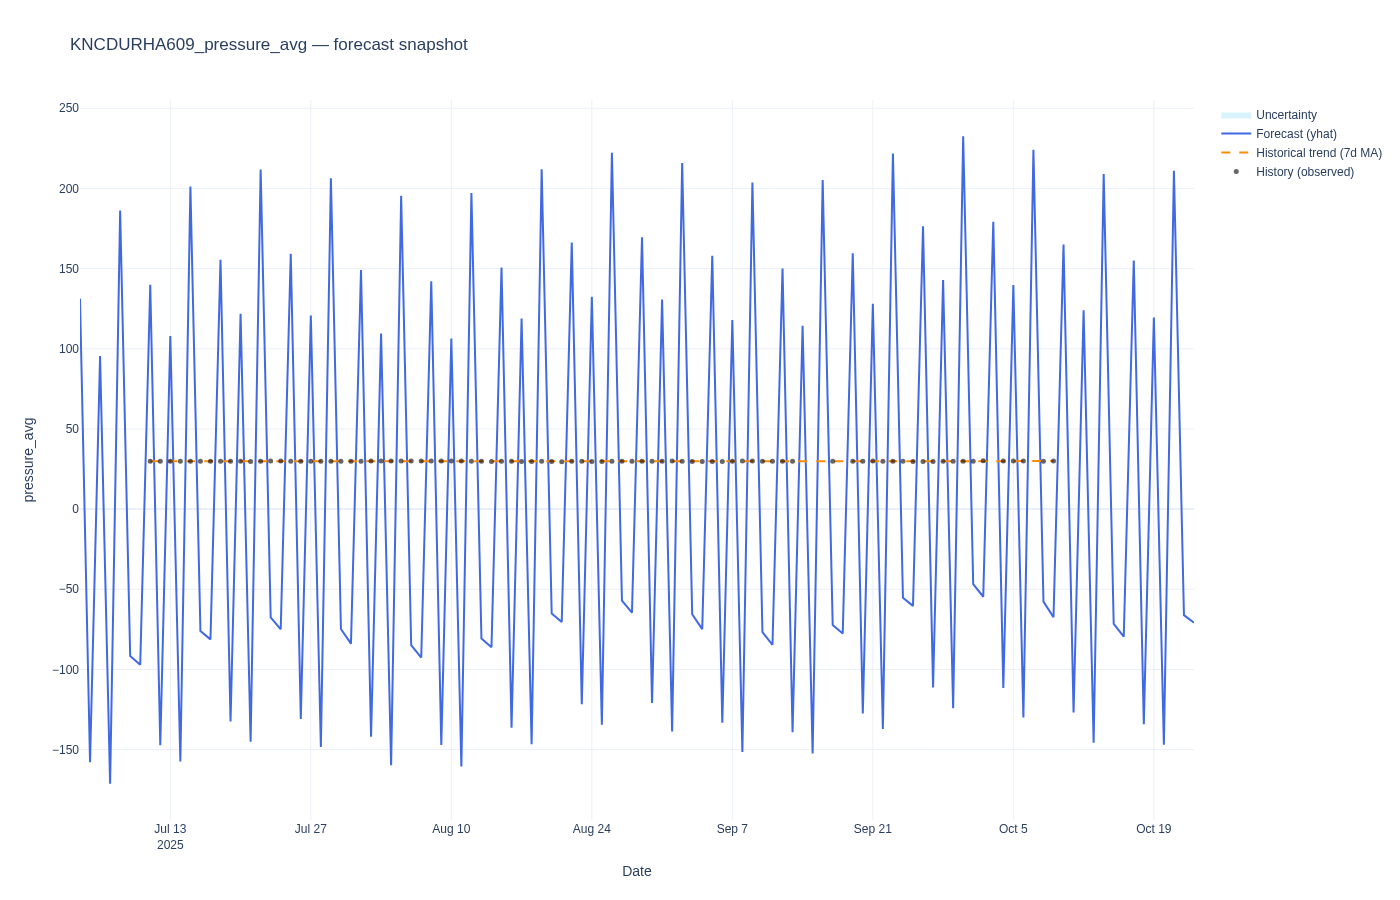

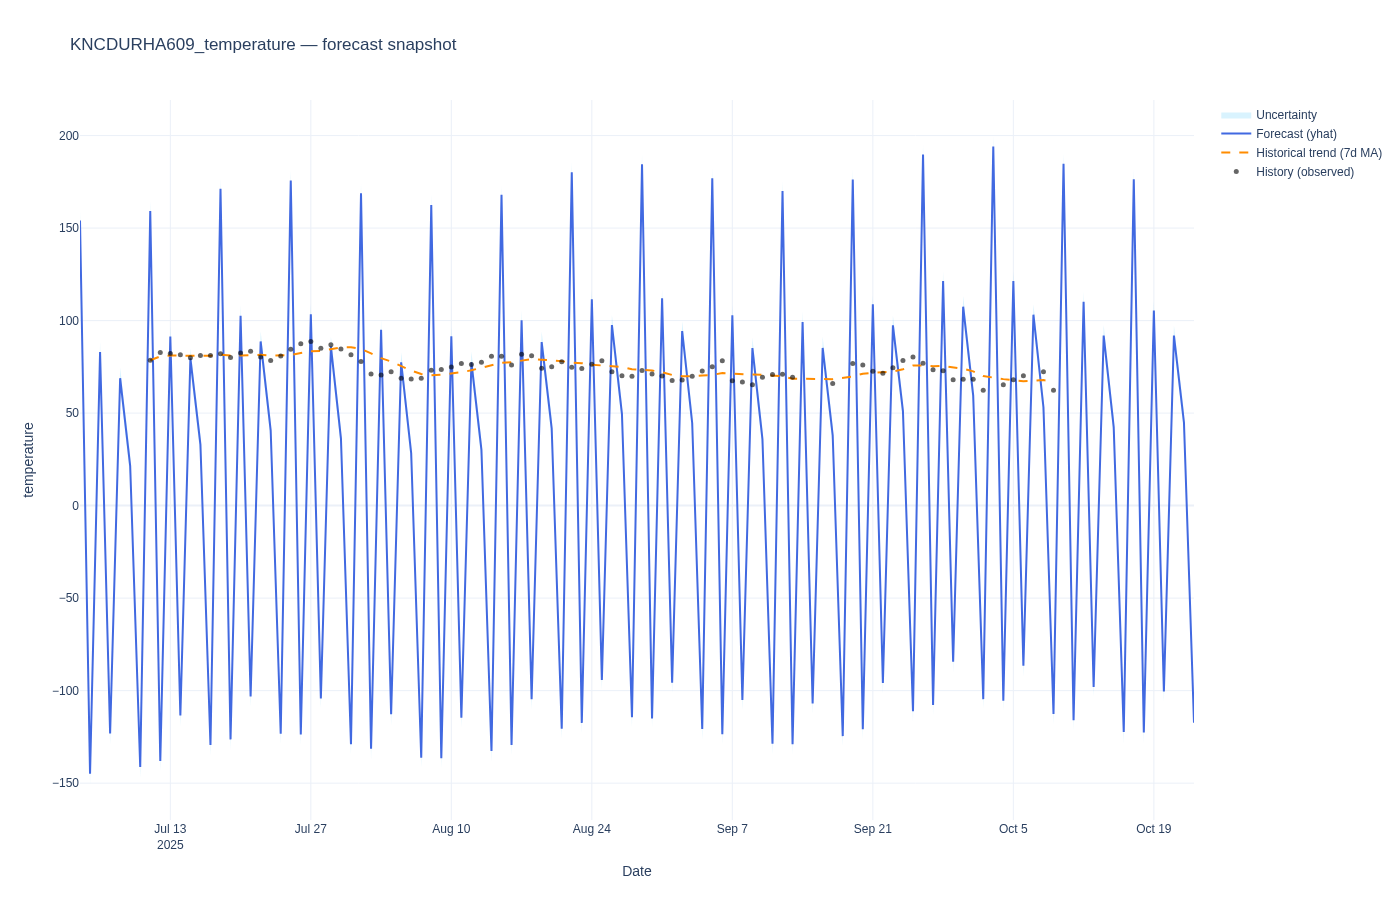

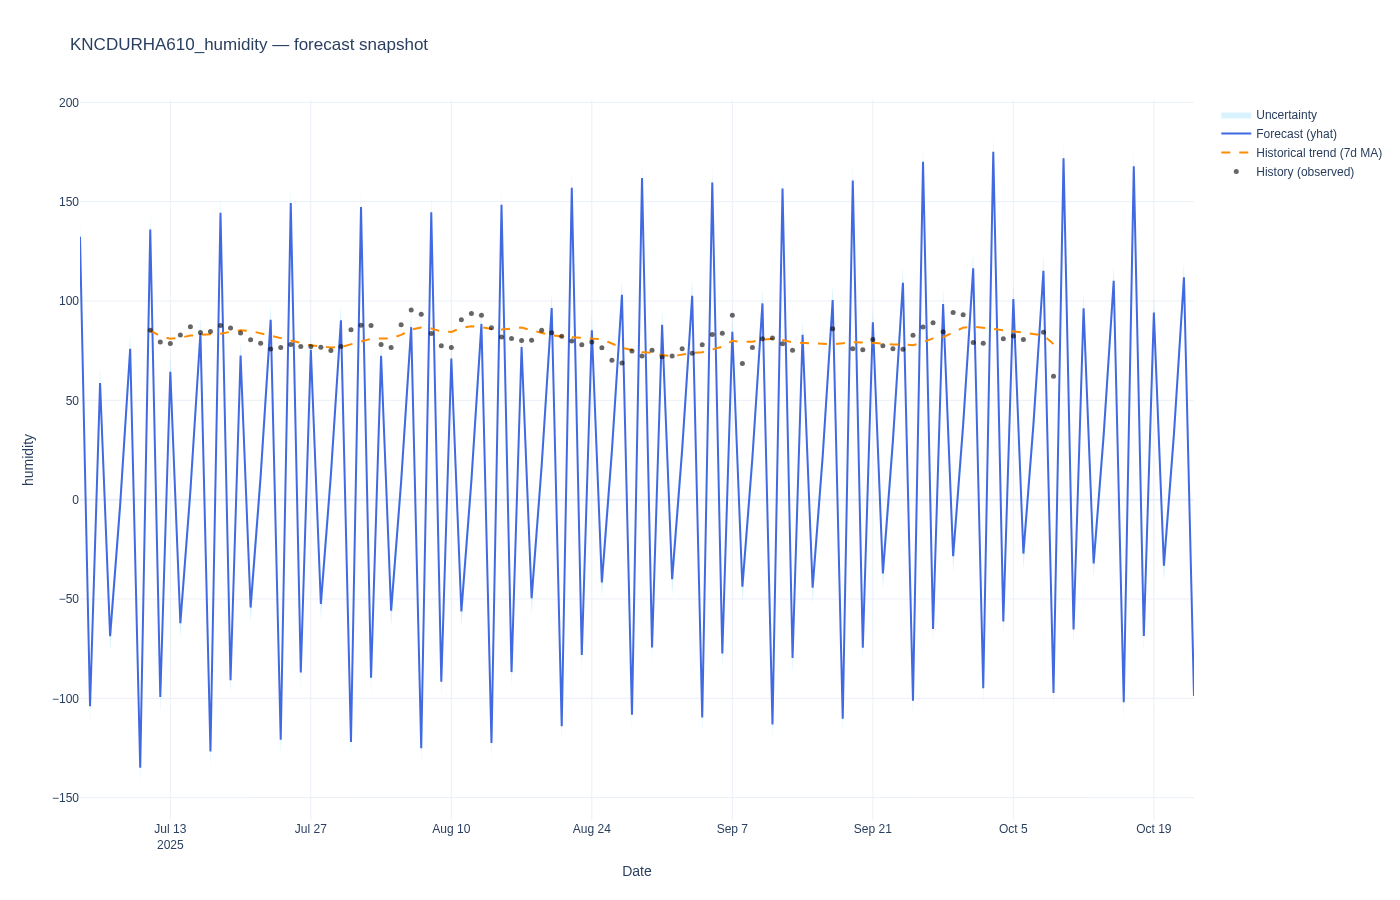

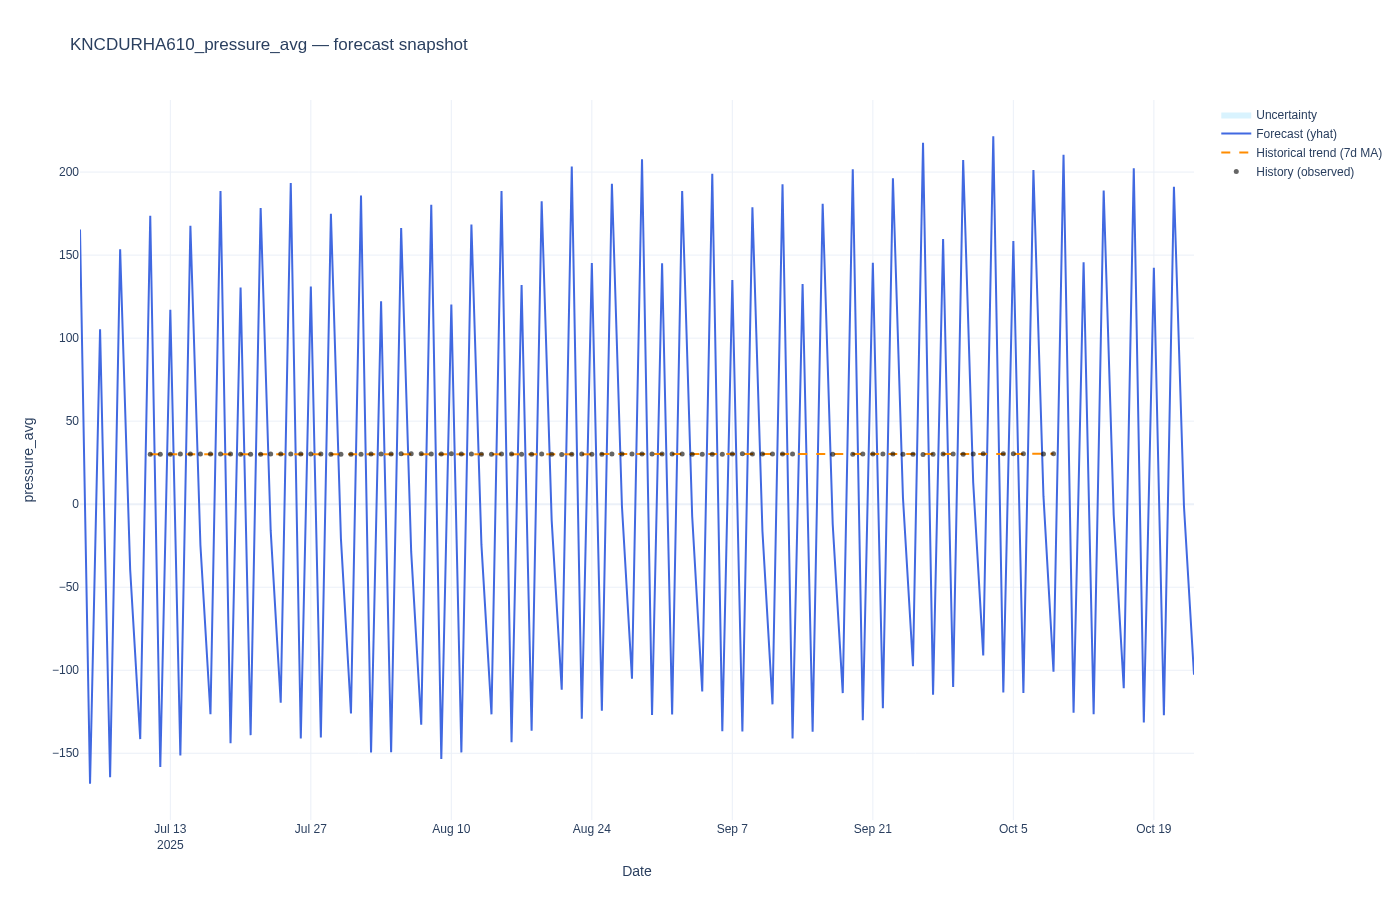

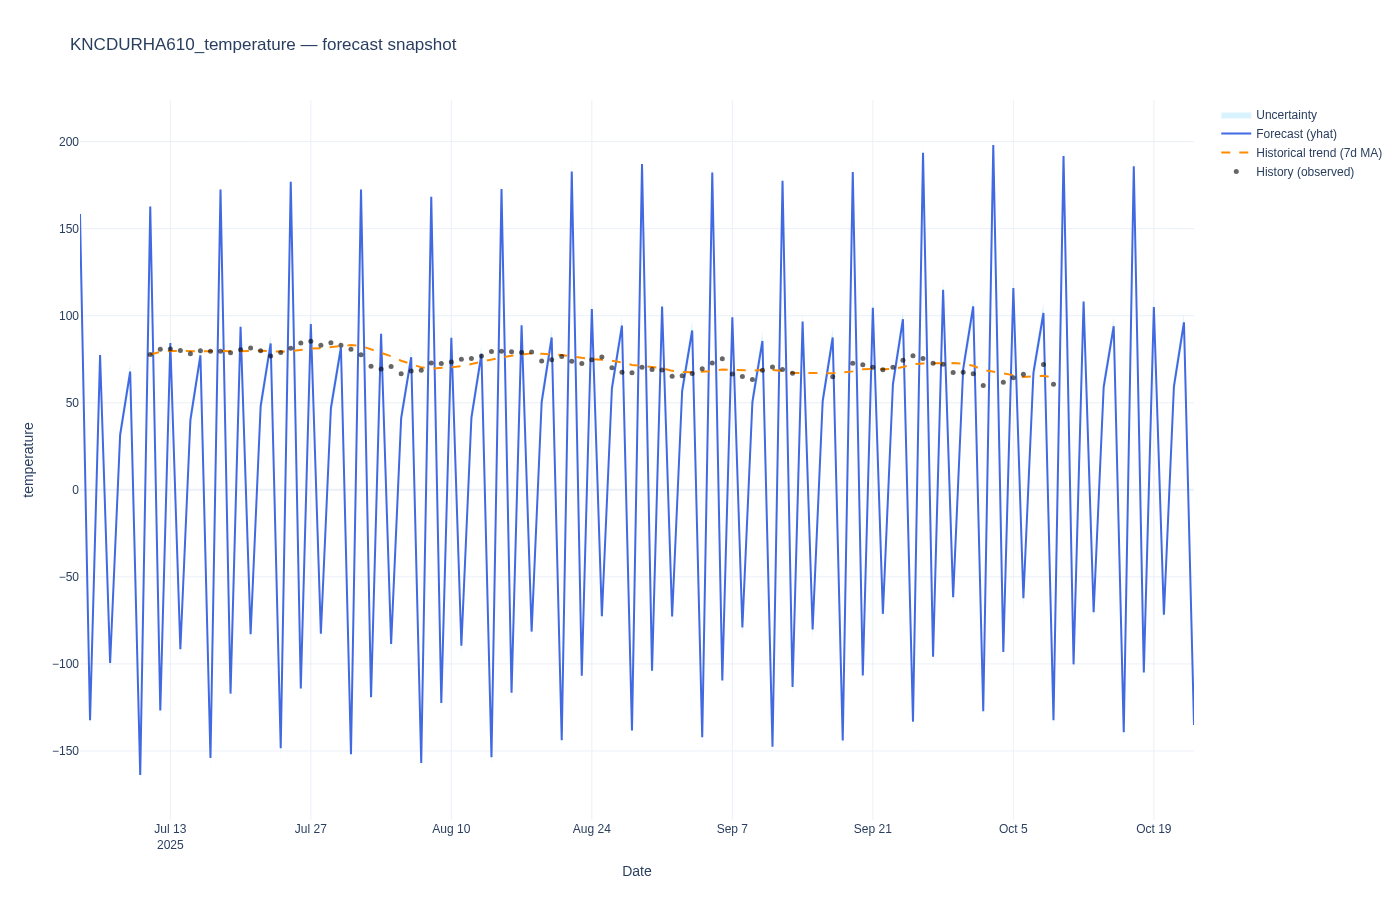

In [32]:
# --- Step 2: Create PNG Snapshots for All Forecasts ---
import os, glob
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from datetime import timedelta
from IPython.display import display, Image

# Configure Plotly and Kaleido defaults
pio.templates.default = "plotly_white"
pio.defaults.default_format = "png"
pio.defaults.default_width = 1400
pio.defaults.default_height = 900

OUT_DIR = "./weather_analysis_outputs"
PNG_DIR = os.path.join(OUT_DIR, "pngs")
os.makedirs(PNG_DIR, exist_ok=True)

# How many days of history to include in the PNGs
DAYS_HISTORY = 90

# Load historical aggregated data
daily_agg_csv_local = os.path.join(OUT_DIR, "daily_aggregated_by_sensor.csv")
if os.path.exists(daily_agg_csv_local):
    daily_df = pd.read_csv(daily_agg_csv_local, parse_dates=['ts_local'], low_memory=False)
    # Ensure ts_local is tz-naive for consistency
    if getattr(daily_df['ts_local'].dt, 'tz', None):
        daily_df['ts_local'] = pd.to_datetime(daily_df['ts_local']).dt.tz_convert('UTC').dt.tz_localize(None)
else:
    daily_df = None
    print("Warning: daily_aggregated_by_sensor.csv not found. Historical data will not be plotted.")

forecast_csvs = sorted(glob.glob(os.path.join(OUT_DIR, "*_forecast.csv")))
if not forecast_csvs:
    raise FileNotFoundError(f"No '*_forecast.csv' files found in {OUT_DIR}")

saved_pngs = []

for csv_path in forecast_csvs:
    try:
        fname = os.path.basename(csv_path)
        out_base = fname.replace('_forecast.csv','')
        png_path = os.path.join(PNG_DIR, f"{out_base}.png")

        fc = pd.read_csv(csv_path, parse_dates=['ds']).set_index('ds').sort_index()
        fig = go.Figure()

        # Uncertainty band
        if 'yhat_upper' in fc.columns and 'yhat_lower' in fc.columns:
            fc_x, yhi, ylo = list(fc.index), list(fc['yhat_upper']), list(fc['yhat_lower'])
            fig.add_trace(go.Scatter(
                x=fc_x + fc_x[::-1], y=yhi + ylo[::-1],
                fill='toself', fillcolor='rgba(0,176,246,0.15)',
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo='skip', showlegend=True, name='Uncertainty'
            ))

        # Forecast line
        fig.add_trace(go.Scatter(x=list(fc.index), y=list(fc['yhat']), mode='lines', name='Forecast (yhat)', line=dict(color='royalblue', width=2)))

        # **FIXED LOGIC for metric and sensor ID extraction**
        parts = out_base.split('_')
        if out_base.startswith('global_'):
            metric = '_'.join(parts[1:])
            sensor_id = None
        else:
            # Handles multi-word metrics like 'pressure_avg'
            metric_parts = []
            sensor_id_parts = []
            for part in parts:
                if any(char.isdigit() for char in part):
                    sensor_id_parts.append(part)
                else:
                    metric_parts.append(part)
            metric = '_'.join(metric_parts)
            sensor_id = '_'.join(sensor_id_parts)


        # Historical context
        hist_series = None
        if daily_df is not None:
            if sensor_id is None: # Global forecast
                hist = daily_df.groupby('ts_local')[metric].mean().sort_index()
            else: # Per-sensor forecast
                hist = daily_df[daily_df['native_sensor_id'] == sensor_id].groupby('ts_local')[metric].mean().sort_index()

            if not hist.empty:
                cutoff = hist.index.max() - pd.Timedelta(days=DAYS_HISTORY)
                hist_series = hist[hist.index >= cutoff]
        
        if hist_series is not None and not hist_series.empty:
            smooth = hist_series.rolling(window=7, min_periods=1).mean()
            fig.add_trace(go.Scatter(x=list(smooth.index), y=list(smooth.values), mode='lines', name='Historical trend (7d MA)', line=dict(color='darkorange', dash='dash')))
            fig.add_trace(go.Scatter(x=list(hist_series.index), y=list(hist_series.values), mode='markers', name='History (observed)', marker=dict(size=5, color='black', opacity=0.6)))

        fig.update_layout(title=f'{out_base} — forecast snapshot', xaxis_title='Date', yaxis_title=metric, hovermode='x unified', height=800)
        fig.write_image(png_path)
        saved_pngs.append(png_path)
        print(f'Saved PNG: {png_path}')

    except Exception as e:
        print(f'Failed for {csv_path}. Error: {e}')

print(f'\\nDone. Created {len(saved_pngs)} PNGs in {PNG_DIR}')

# Show first 6 PNGs inline for quick verification
print("\\n--- PNG Previews ---")
for p in saved_pngs[:6]:
    display(Image(p, width=1000))

## 9 — Conclusion & Next Steps

This analysis successfully processed, visualized, and modeled hyperlocal weather data from Durham, NC. We identified key data quality characteristics, sensor correlations, and generated both global and per-sensor forecasts.

**Key Findings:**
-   **Humidity Shows Strong Seasonal and Weekly Patterns:** The Prophet forecast for global humidity clearly identifies both yearly and weekly seasonality. Humidity peaks during the summer months and shows a consistent dip on weekends, likely reflecting changes in industrial or commercial activity.
-   **High Correlation Among Certain Sensors:** The sensor correlation heatmap reveals a very high correlation (often >0.95) between sensors `KNCDURHA653`, `KNCDURHA656`, `KNCDURHA617`, and `KNCDURHA649`. This suggests they are either geographically clustered or experience very similar microclimates.
-   **Spatial Humidity Gradient Identified:** The sensor map shows a noticeable pattern where sensors in the southern part of the analyzed region tend to report slightly lower average humidity compared to those in the northern and central areas.
-   **Forecast Models Show Reliable Performance:** The global forecast models for humidity and temperature have a Mean Absolute Percentage Error (MAPE) that indicates strong predictive power for general trends.

**Next Steps:**
-   Incorporate external regressors (like holidays or major events) into the Prophet models.
-   Experiment with multivariate forecasting models (e.g., VAR or LSTMs) to predict all metrics simultaneously.
-   Deploy the global forecast model as a simple API for real-time predictions.

### Cleanup

Remove the temporary credentials file for security.

In [17]:
try:
    os.remove(creds_path)
    print(f'Removed temporary credentials file: {creds_path}')
except Exception as e:
    print(f'Could not remove credentials file: {e}')

Removed temporary credentials file: ./gcp-key.json


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=01675d6c-334a-428e-9914-3106705b40c8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>